# Building your own algorithm container

With Amazon SageMaker, you can package your own algorithms that can than be trained and deployed in the SageMaker environment. This notebook will guide you through an example that shows you how to build a Docker container for SageMaker and use it for training and inference.

By packaging an algorithm in a container, you can bring almost any code to the Amazon SageMaker environment, regardless of programming language, environment, framework, or dependencies. 

You can bring your own PyTorch algorithms to SageMaker by extending SageMaker's pre-built container image. (https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms.html). We recommend the pre-built container be considered first. This example aims to demonstrate on bringing in your own Mask RCNN model to SageMaker as your own container for training and serving. 

1. [Building your own algorithm container](#Building-your-own-algorithm-container)
  1. [When should I build my own algorithm container?](#When-should-I-build-my-own-algorithm-container%3F)
  1. [Permissions](#Permissions)
  1. [The example](#The-example)
  1. [The presentation](#The-presentation)
1. [Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker](#Part-1%3A-Packaging-and-Uploading-your-Algorithm-for-use-with-Amazon-SageMaker)
    1. [An overview of Docker](#An-overview-of-Docker)
    1. [How Amazon SageMaker runs your Docker container](#How-Amazon-SageMaker-runs-your-Docker-container)
      1. [Running your container during training](#Running-your-container-during-training)
        1. [The input](#The-input)
        1. [The output](#The-output)
      1. [Running your container during hosting](#Running-your-container-during-hosting)
    1. [The parts of the sample container](#The-parts-of-the-sample-container)
    1. [The Dockerfile](#The-Dockerfile)
    1. [Building and registering the container](#Building-and-registering-the-container)
  1. [Testing your algorithm on your local machine or on an Amazon SageMaker notebook instance](#Testing-your-algorithm-on-your-local-machine-or-on-an-Amazon-SageMaker-notebook-instance)
1. [Part 2: Using your Algorithm in Amazon SageMaker](#Part-2%3A-Using-your-Algorithm-in-Amazon-SageMaker)
  1. [Set up the environment](#Set-up-the-environment)
  1. [Create the session](#Create-the-session)
  1. [Upload the data for training](#Upload-the-data-for-training)
  1. [Create an estimator and fit the model](#Create-an-estimator-and-fit-the-model)
  1. [Hosting your model](#Hosting-your-model)
    1. [Deploy the model](#Deploy-the-model)
    2. [Choose some data and use it for a prediction](#Choose-some-data-and-use-it-for-a-prediction)
    3. [Optional cleanup](#Optional-cleanup)
  1. [Run Batch Transform Job](#Run-Batch-Transform-Job)
    1. [Create a Transform Job](#Create-a-Transform-Job)
    2. [View Output](#View-Output)

_or_ I'm impatient, just [let me see the code](#The-Dockerfile)!

## When should I build my own algorithm container?

You may not need to create a container to bring your own code to Amazon SageMaker. When you are using a framework (such as Apache MXNet or TensorFlow) that has direct support in SageMaker, you can simply supply the Python code that implements your algorithm using the SDK entry points for that framework. This set of frameworks is continually expanding, so we recommend that you check the current list if your algorithm is written in a common machine learning environment.

Even if there is direct SDK support for your environment or framework, you may find it more effective to build your own container. If the code that implements your algorithm is quite complex on its own or you need special additions to the framework, building your own container may be the right choice.

If there isn't direct SDK support for your environment, don't worry. You'll see in this walk-through that building your own container is quite straightforward.

## Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because we'll creating new repositories in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

## The example

The Mask R-CNN part of the code is based on the TorchVision Object Detection Funetuning Tutorial (https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html). To learn more about Mask R-CNN, please refer to the original paper published in 2017 (https://arxiv.org/abs/1703.06870).

## The presentation

This presentation is divided into two parts: _building_ the container and _using_ the container.

# Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new concept, but they are not difficult, as you'll see here. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way you set up your program is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, environment variable, etc.

In some ways, a Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run on the same physical machine or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. We'll see an example of that below. You can build your Docker images based on Docker images built by yourself or others, which can simplify things quite a bit.

Docker has become very popular in the programming and devops communities for its flexibility and well-defined specification of the code to be run. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a certain way for training and a slightly different way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

Because you can run the same image in training or hosting, Amazon SageMaker runs your container with the argument `train` or `serve`. How your container processes this argument depends on the container:

* In the example here, we don't define an `ENTRYPOINT` in the Dockerfile so Docker will run the command `train` at training time and `serve` at serving time. In this example, we define these as executable Python scripts, but they could be any program that we want to start in that environment.
* If you specify a program as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and its first argument will be `train` or `serve`. The program can then look at that argument and decide what to do.
* If you are building separate containers for training and hosting (or building only for one or the other), you can define a program as an `ENTRYPOINT` in the Dockerfile and ignore (or verify) the first argument passed in. 

#### Running your container during training

When Amazon SageMaker runs training, your `train` script is run just like a regular Python program. A number of files are laid out for your use, under the `/opt/ml` directory:

    /opt/ml
    ├── input
    │   ├── config
    │   │   ├── hyperparameters.json
    │   │   └── resourceConfig.json
    │   └── data
    │       └── <channel_name>
    │           └── <input data>
    ├── model
    │   └── <model files>
    └── output
        └── failure

##### The input

* `/opt/ml/input/config` contains information to control how your program runs. `hyperparameters.json` is a JSON-formatted dictionary of hyperparameter names to values. These values will always be strings, so you may need to convert them. `resourceConfig.json` is a JSON-formatted file that describes the network layout used for distributed training. Since scikit-learn doesn't support distributed training, we'll ignore it here.
* `/opt/ml/input/data/<channel_name>/` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob but it's generally important that channels match what the algorithm expects. The files for each channel will be copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure. 
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.

##### The output

* `/opt/ml/model/` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker will package any files in this directory into a compressed tar archive file. This file will be available at the S3 location returned in the `DescribeTrainingJob` result.
* `/opt/ml/output` is a directory where the algorithm can write a file `failure` that describes why the job failed. The contents of this file will be returned in the `FailureReason` field of the `DescribeTrainingJob` result. For jobs that succeed, there is no reason to write this file as it will be ignored.

#### Running your container during hosting

Hosting has a very different model than training because hosting is reponding to inference requests that come in via HTTP. In this example, we use our recommended Python serving stack to provide robust and scalable serving of inference requests:

![Request serving stack](stack.png)

This stack is implemented in the sample code here and you can mostly just leave it alone. 

Amazon SageMaker uses two URLs in the container:

* `/ping` will receive `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these will be passed in as well. 

The container will have the model files in the same place they were written during training:

    /opt/ml
    └── model
        └── <model files>



### The parts of the sample container

In the `container` directory are all the components you need to package the sample algorithm for Amazon SageMager:

    .
    ├── Dockerfile
    ├── build_and_push.sh
    └── mask_r_cnn
        ├── nginx.conf
        ├── predictor.py
        ├── serve
        ├── wsgi.py
        ├── transforms.py
        ├── utils.py
        ├── coco_eval.py
        ├── coco_utils.py
        ├── engine.py
        └── helper.py
        
        

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details below.
* __`build_and_push.sh`__ is a script that uses the Dockerfile to build your container images and then pushes it to ECR. We'll invoke the commands directly later in this notebook, but you can just copy and run the script for your own algorithms.
* __`mask_r_cnn`__ is the directory which contains the files that will be installed in the container.


In this simple application, we only install five files in the container. You may only need that many or, if you have many supporting routines, you may wish to install more. These five show the standard structure of our Python containers, although you are free to choose a different toolset and therefore could have a different layout. If you're writing in a different programming language, you'll certainly have a different layout depending on the frameworks and tools you choose.

The files that we'll put in the container are:

* __`nginx.conf`__ is the configuration file for the nginx front-end. Generally, you should be able to take this file as-is.
* __`predictor.py`__ is the program that actually implements the Flask web server and the decision tree predictions for this app. 
* __`serve`__ is the program started when the container is started for hosting. It simply launches the gunicorn server which runs multiple instances of the Flask app defined in `predictor.py`. You should be able to take this file as-is.
* __`train`__ is the program that is invoked when the container is run for training. 
* __`wsgi.py`__ is a small wrapper used to invoke the Flask app. You should be able to take this file as-is.

We have customized `train.py` and `predictor.py` for fine tuning Mask R-CNN during training, and for loading tuned model, deserializing request data, making prediction, and sending back the serialized results.

### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

For the Python science stack, we will start from a standard Ubuntu installation and run the normal tools to install the things needed by scikit-learn. Finally, we add the code that implements our specific algorithm to the container and set up the right environment to run under.

Along the way, we clean up extra space. This makes the container smaller and faster to start.

Let's look at the Dockerfile for the example:

In [ ]:
!cat container/Dockerfile

### Building and registering the container

The following shell code shows how to build the container image using `docker build` and push the container image to ECR using `docker push`. This code is also available as the shell script `container/build-and-push.sh`, which you can run as `build-and-push.sh decision_trees_sample` to build the image `decision_trees_sample`. 

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this will be the region where the notebook instance was created). If the repository doesn't exist, the script will create it.

In [ ]:
%%sh

# The name of our algorithm
algorithm_name=mask-r-cnn

cd container

chmod +x mask_r_cnn/train
chmod +x mask_r_cnn/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

# Part 2: Using your Algorithm in Amazon SageMaker

Once you have your container packaged, you can use it to train models and use the model for hosting or batch transforms. Let's do that with the algorithm we made above.

## Set up the environment

Here we specify a bucket to use and the role that will be used for working with SageMaker.

In [ ]:
# Define IAM role
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()

## Create the session

The session remembers our connection parameters to SageMaker. We'll use it to perform all of our SageMaker operations.

In [81]:
import sagemaker as sage
from time import gmtime, strftime

sess = sage.Session()

bucket = sess.default_bucket()
prefix_input = 'DEMO-Mask-R-CNN'
prefix_output = 'DEMO-Mask-R-CNN_output'

## Upload the data for training

When training large models with huge amounts of data, you'll typically use big data tools, like Amazon Athena, AWS Glue, or Amazon EMR, to create your data in S3. For the purposes of this example, we're using some the classic [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), which we have included. 

We can use use the tools provided by the SageMaker Python SDK to upload the data to a default bucket. 

First, we need to download data for this sample notebook and upload it to S3. 

In [82]:
%%bash
curl -o ./PennFudanPed.zip  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
unzip PennFudanPed.zip

Archive:  PennFudanPed.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.2M  100 51.2M    0     0  5594k      0  0:00:09  0:00:09 --:--:-- 4845k
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [84]:
!aws s3 cp PennFudanPed s3://$bucket/$prefix_input/PennFudanPed --recursive

upload: PennFudanPed/Annotation/FudanPed00002.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00002.txt
upload: PennFudanPed/Annotation/FudanPed00003.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00003.txt
upload: PennFudanPed/Annotation/FudanPed00004.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00004.txt
upload: PennFudanPed/Annotation/FudanPed00001.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00001.txt
upload: PennFudanPed/Annotation/FudanPed00005.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00005.txt
upload: PennFudanPed/Annotation/FudanPed00011.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00011.txt
upload: PennFudanPed/Annotation/FudanPed00013.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN

upload: PennFudanPed/Annotation/FudanPed00063.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00063.txt
upload: PennFudanPed/Annotation/FudanPed00068.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00068.txt
upload: PennFudanPed/Annotation/FudanPed00071.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00071.txt
upload: PennFudanPed/Annotation/FudanPed00072.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00072.txt
upload: PennFudanPed/Annotation/FudanPed00070.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00070.txt
upload: PennFudanPed/Annotation/FudanPed00067.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/FudanPed00067.txt
upload: PennFudanPed/Annotation/PennPed00001.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/

upload: PennFudanPed/Annotation/PennPed00055.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/PennPed00055.txt
upload: PennFudanPed/Annotation/PennPed00057.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/PennPed00057.txt
upload: PennFudanPed/Annotation/PennPed00060.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/PennPed00060.txt
upload: PennFudanPed/Annotation/PennPed00053.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/PennPed00053.txt
upload: PennFudanPed/Annotation/PennPed00054.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/PennPed00054.txt
upload: PennFudanPed/Annotation/PennPed00059.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/PennPed00059.txt
upload: PennFudanPed/Annotation/PennPed00058.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed

upload: PennFudanPed/PNGImages/FudanPed00012.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/FudanPed00012.png
upload: PennFudanPed/PNGImages/FudanPed00018.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/FudanPed00018.png
upload: PennFudanPed/PNGImages/FudanPed00017.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/FudanPed00017.png
upload: PennFudanPed/Annotation/PennPed00082.txt to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/Annotation/PennPed00082.txt
upload: PennFudanPed/PNGImages/FudanPed00019.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/FudanPed00019.png
upload: PennFudanPed/PNGImages/FudanPed00020.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/FudanPed00020.png
upload: PennFudanPed/PNGImages/FudanPed00014.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed

upload: PennFudanPed/PNGImages/FudanPed00072.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/FudanPed00072.png
upload: PennFudanPed/PNGImages/PennPed00002.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/PennPed00002.png
upload: PennFudanPed/PNGImages/FudanPed00073.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/FudanPed00073.png
upload: PennFudanPed/PNGImages/FudanPed00074.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/FudanPed00074.png
upload: PennFudanPed/PNGImages/FudanPed00063.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/FudanPed00063.png
upload: PennFudanPed/PNGImages/PennPed00003.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/PennPed00003.png
upload: PennFudanPed/PNGImages/PennPed00008.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGI

upload: PennFudanPed/PNGImages/PennPed00059.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/PennPed00059.png
upload: PennFudanPed/PNGImages/PennPed00058.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/PennPed00058.png
upload: PennFudanPed/PNGImages/PennPed00062.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/PennPed00062.png
upload: PennFudanPed/PNGImages/PennPed00061.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/PennPed00061.png
upload: PennFudanPed/PNGImages/PennPed00060.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/PennPed00060.png
upload: PennFudanPed/PNGImages/PennPed00064.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/PennPed00064.png
upload: PennFudanPed/PNGImages/PennPed00051.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PNGImages/Pe

upload: PennFudanPed/PedMasks/FudanPed00017_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/FudanPed00017_mask.png
upload: PennFudanPed/PedMasks/FudanPed00020_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/FudanPed00020_mask.png
upload: PennFudanPed/PedMasks/FudanPed00002_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/FudanPed00002_mask.png
upload: PennFudanPed/PedMasks/FudanPed00023_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/FudanPed00023_mask.png
upload: PennFudanPed/PedMasks/FudanPed00025_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/FudanPed00025_mask.png
upload: PennFudanPed/PedMasks/FudanPed00027_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/FudanPed00027_mask.png
upload: PennFudanPed/PedMasks/FudanPed00026_mask.png to s3://sagemaker

upload: PennFudanPed/PedMasks/PennPed00001_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00001_mask.png
upload: PennFudanPed/PedMasks/PennPed00008_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00008_mask.png
upload: PennFudanPed/PedMasks/PennPed00007_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00007_mask.png
upload: PennFudanPed/PedMasks/PennPed00010_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00010_mask.png
upload: PennFudanPed/PedMasks/PennPed00013_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00013_mask.png
upload: PennFudanPed/PedMasks/PennPed00015_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00015_mask.png
upload: PennFudanPed/PedMasks/PennPed00014_mask.png to s3://sagemaker-us-east-1-08

upload: PennFudanPed/PedMasks/PennPed00061_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00061_mask.png
upload: PennFudanPed/PedMasks/PennPed00063_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00063_mask.png
upload: PennFudanPed/PedMasks/PennPed00060_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00060_mask.png
upload: PennFudanPed/PedMasks/PennPed00066_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00066_mask.png
upload: PennFudanPed/PedMasks/PennPed00064_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00064_mask.png
upload: PennFudanPed/PedMasks/PennPed00069_mask.png to s3://sagemaker-us-east-1-084313272408/DEMO-Mask-R-CNN/PennFudanPed/PedMasks/PennPed00069_mask.png
upload: PennFudanPed/PedMasks/PennPed00065_mask.png to s3://sagemaker-us-east-1-08

In [85]:
data_location = "s3://{}/{}".format(bucket, prefix_input)

## Create an estimator and fit the model

In order to use SageMaker to fit our algorithm, we'll create an `Estimator` that defines how to use the container to train. This includes the configuration we need to invoke SageMaker training:

* The __container name__. This is constructed as in the shell commands above.
* The __role__. As defined above.
* The __instance count__ which is the number of machines to use for training.
* The __instance type__ which is the type of machine to use for training.
* The __output path__ determines where the model artifact will be written.
* The __session__ is the SageMaker session object that we defined above.

Then we use fit() on the estimator to train against the data that we uploaded above. We use 1 epochs for demonstration purpose. Please feel free to increase `num_epochs` as needed. 

In [86]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/mask-r-cnn:latest'.format(account, region)

maskrcnn = sage.estimator.Estimator(image,
                       role, 1, 'ml.p2.xlarge',
                       output_path="s3://{}/{}".format(sess.default_bucket(), prefix_output),
                       sagemaker_session=sess)

maskrcnn.set_hyperparameters(num_epochs = 1,
                              num_classes = 2)

maskrcnn.fit(data_location)

2020-01-31 15:57:05 Starting - Starting the training job...
2020-01-31 15:57:06 Starting - Launching requested ML instances......
2020-01-31 15:58:10 Starting - Preparing the instances for training......
2020-01-31 15:59:34 Downloading - Downloading input data
2020-01-31 15:59:34 Training - Downloading the training image............
2020-01-31 16:01:29 Training - Training image download completed. Training in progress..Starting the training.
{'num_epochs': '1', 'num_classes': '2'}
['Annotation', 'added-object-list.txt', 'PNGImages', 'PedMasks', 'readme.txt']
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
#015  0%|          | 0.00/170M [00:00<?, ?B/s]#015  5%|5         | 9.12M/170M [00:00<00:01, 95.6MB/s]#015 11%|#         | 18.6M/170M [00:00<00:01, 96.6MB/s]#015 16%|#5        | 26.5M/170M [00:00<00:01, 92.1MB/s]#015 21%|##        | 35.6M/170M [00:00<00:01, 93.0MB/s]#015

## Hosting your model
You can use a trained model to get real time predictions using HTTP endpoint. Follow these steps to walk you through the process.

### Deploy the model

Deploying the model to SageMaker hosting just requires a `deploy` call on the fitted model. This call takes an instance count, instance type, and optionally serializer and deserializer functions. These are used when the resulting predictor is created on the endpoint.

In [139]:
#from sagemaker.predictor import csv_serializer
predictor = maskrcnn.deploy(1, 'ml.c4.xlarge', endpoint_name='mask-r-cnn-2019-10-12-06-23-29-664')#,update_endpoint=True)
#ml.p2.xlarge

Using already existing model: mask-r-cnn-2020-01-31-15-57-05-185


-------------------!

### Run code below if you want to run inference on existing endpoint. 

All you need to do is enter the right endpoint name. 

In [89]:
# import sagemaker
# predictor = sagemaker.predictor.RealTimePredictor(endpoint='<endpoint name>')

### Choose some data and use it for a prediction

In order to do some predictions, we'll extract some of the data we used for training and do predictions against it. This is, of course, bad statistical practice, but a good way to see how the mechanism works.

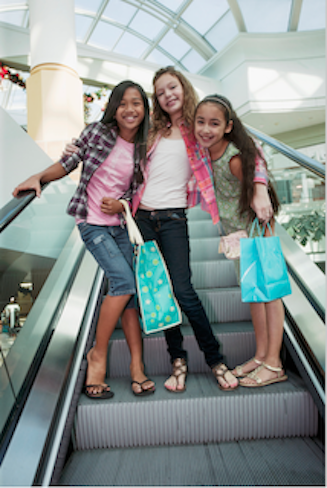

In [162]:
from PIL import Image
import numpy as np
import pickle
f = 't1.png'
Image.open(f)

In [164]:
img = Image.open(f)
img = np.array(img)[:,:,0:3]# if want to pass as np array. This is optional. 
img.shape

(488, 327, 3)

In [171]:
import json
payload = json.dumps(img.tolist())

In [172]:
result = predictor.predict(b)

In [173]:
prediction = json.loads(result)

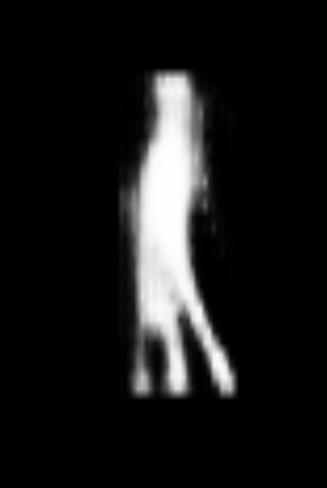

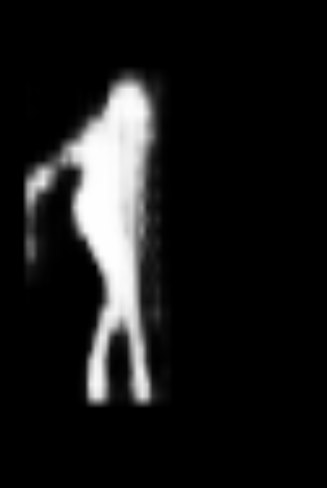

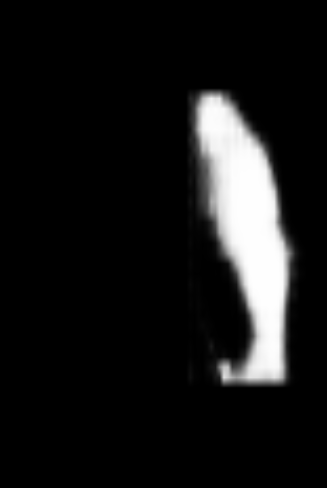

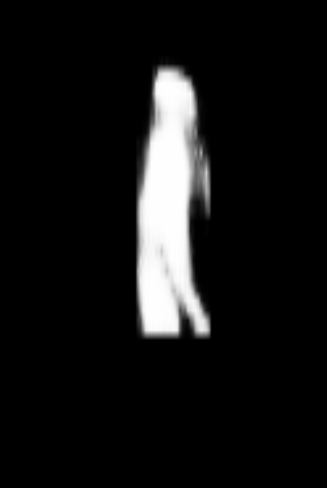

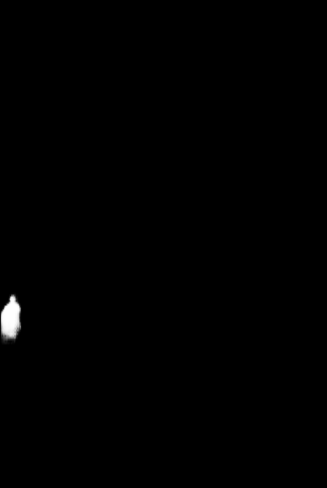

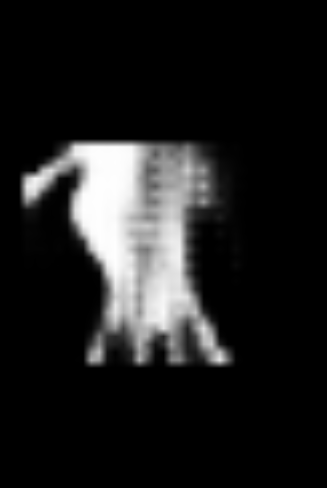

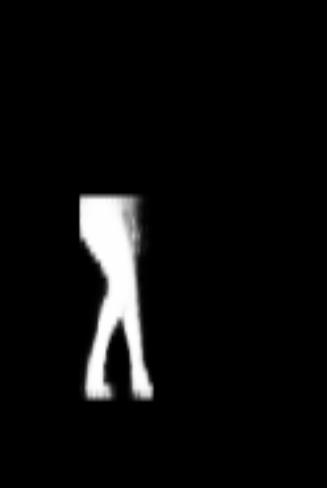

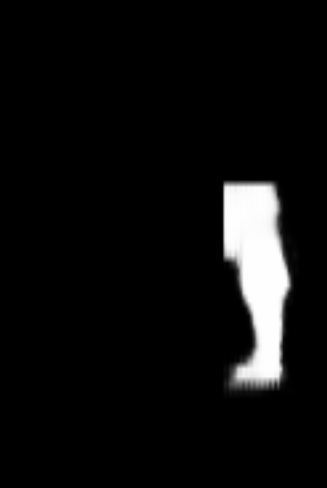

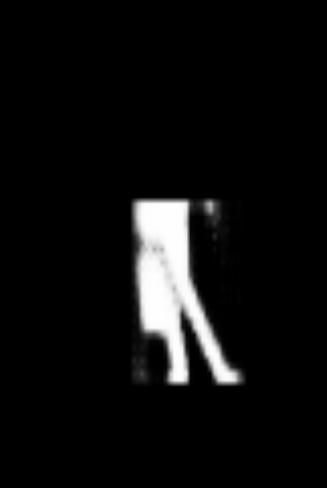

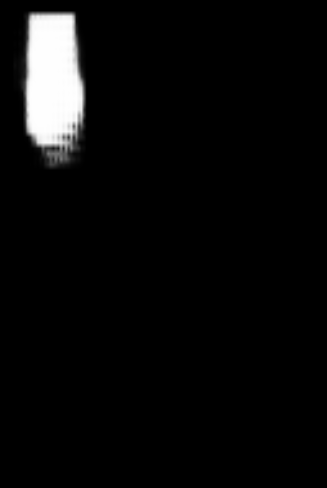

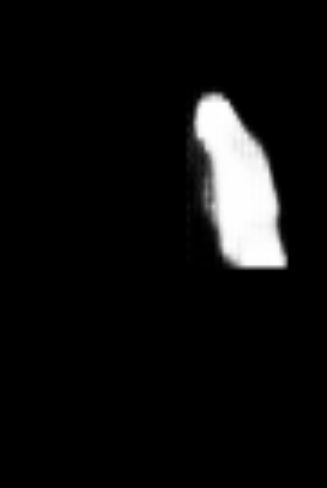

In [170]:
for i in range(len(prediction)):
    x = Image.fromarray(np.uint8(np.asarray(prediction[i][0])*255))
    display(x)

In [ ]:
Image.fromarray(np.uint8(np.asarray(prediction[1][0])*255))

### Optional cleanup
When you're done with the endpoint, you'll want to clean it up.

In [ ]:
sess.delete_endpoint(predictor.endpoint)